In [1]:
import numpy as np
import cv2 
import re
from PIL import Image
import pandas as pd
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

from tqdm import tqdm_notebook as tqdm 
import matplotlib.pyplot as plt
%matplotlib inline

ROOT = '/home/user/data/twins_aligned_eyes_resized'

In [2]:
FACIAL_LANDMARKS_68_IDXS = dict(
    [("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))]
)

In [12]:
from transforms import get_transform_base, get_transform_kp, std, mean
from twins import ClassificationDataset, get_image_and_landmarks, imread

# define crop transform of your choice
size = 512

# center crop + normalize
transform_base = get_transform_base(size)

# same as above + support for keypoints
transform_kp = get_transform_kp(size)

In [4]:
DF_ROOT = '/home/user/data/twins_aligned_cropped_resized'

# front images for each id
views = pd.read_csv(os.path.join(DF_ROOT, 'df', 'views.csv'), index_col=0)
views.index = views.index.astype(str)
views.filename = views.filename.apply(eval)

# pairs including 50% of same identities
pairs = pd.read_csv(os.path.join(DF_ROOT, 'df', 'pairs.csv'))

In [5]:
clf_dataset = ClassificationDataset(ROOT, views, transform=None, keypoints=True)

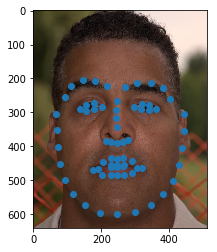

In [7]:
sample = clf_dataset[0]

src_image = sample['img']
kp = sample['keypoints']

plt.imshow(src_image)
plt.scatter(kp[:,0], kp[:,1])

In [8]:
FACIAL_LANDMARKS_68_IDXS

{'mouth': (48, 68),
 'inner_mouth': (60, 68),
 'right_eyebrow': (17, 22),
 'left_eyebrow': (22, 27),
 'right_eye': (36, 42),
 'left_eye': (42, 48),
 'nose': (27, 36),
 'jaw': (0, 17)}

In [9]:
def to_int_tuple(p):
    return tuple([int(x) for x in p])

def get_landmark_image(src_image, kp):   
    lnd_image = np.zeros_like(src_image)
    
    colors = {
        'mouth': (200,0,100),
        'right_eyebrow': (0, 100, 100),
         'left_eyebrow': (0, 100, 100),
         'right_eye': (0, 100, 800),
         'left_eye': (0, 100, 800),
         'nose': (50, 200, 50),
         'jaw': (100, 0, 50)}

    for key in colors:
        low, high = FACIAL_LANDMARKS_68_IDXS[key]
        for i in range(low, high-1):
            p0, p1 = to_int_tuple(kp[i]), to_int_tuple(kp[i+1])
            lnd_image = cv2.line(lnd_image, p0, p1, colors[key], 5)
    return lnd_image

In [15]:
def valid(img):
    return img.endswith('.jpg') and 'landmark' not in img

twins_ids = os.listdir(ROOT)
for person_id in tqdm(twins_ids):
    images = os.listdir(os.path.join(ROOT, person_id))
    images = [image for image in images if valid(image)]
#     print(images)
     
    for i, img_id in tqdm(enumerate(images), total = len(images)):
        src_image, kp = get_image_and_landmarks(ROOT, f'{person_id}/{img_id}')
#         kp = pd.read_csv(os.path.join(ROOT, person_id, 'keypoints.csv'))
#         keypoints = parse_keypoints(kp[img_id])
        
        lnd_image = get_landmark_image(src_image, kp)
        
        landmark_path = os.path.join(ROOT, person_id, img_id.split('.')[0]+'_landmark.jpg')
#         print(landmark_path)
        cv2.imwrite(landmark_path, lnd_image)

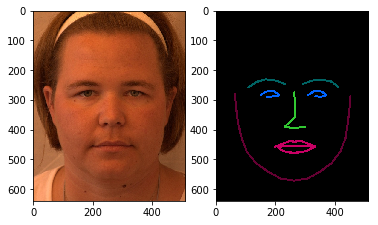

In [17]:
sample = clf_dataset[30]

src_image = sample['img']
kp = sample['keypoints']

lnd_image = get_landmark_image(src_image, kp)
f,a=plt.subplots(1,2, figsize=(6,6))
a[0].imshow(src_image)
a[1].imshow(lnd_image)

In [47]:
cv2.imwrite( 'sample.jpg', lnd_image,)

True

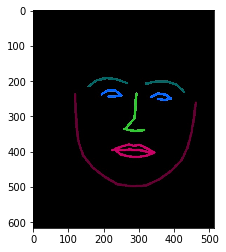

In [48]:
im = cv2.imread('sample.jpg')
plt.imshow(im)

In [9]:
from albumentations import CenterCrop, Compose, VerticalFlip
from albumentations.torch import ToTensor

size = 512
transform = Compose([CenterCrop(size, size), ToTensor()], p=1,
        additional_targets={'image1': 'image'})

In [10]:
clf_dataset = ClassificationDataset(ROOT, views, transform=transform, keypoints=False, landmarks=True)

In [11]:
clf_dataset[0]['image'].shape

torch.Size([6, 512, 512])

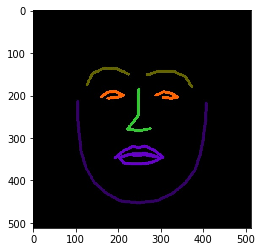

In [13]:
plt.imshow(clf_dataset[0]['image'].numpy()[3:].transpose(1,2,0))